In [1]:
import numpy as np
import matplotlib.pyplot as plt

from jax import jit, vmap, config
import jax.numpy as jnp
import jax.random as jr
import jax.scipy.linalg as jsl

import models as m
from sim_data import residuals
import likelihood as l

import numpyro
import numpyro.distributions as dist

from emcee.autocorr import integrated_time
import pandas as pd
from chainconsumer import ChainConsumer, Chain, Truth

# use double precision
config.update('jax_enable_x64', True)

%load_ext autoreload
%autoreload 2

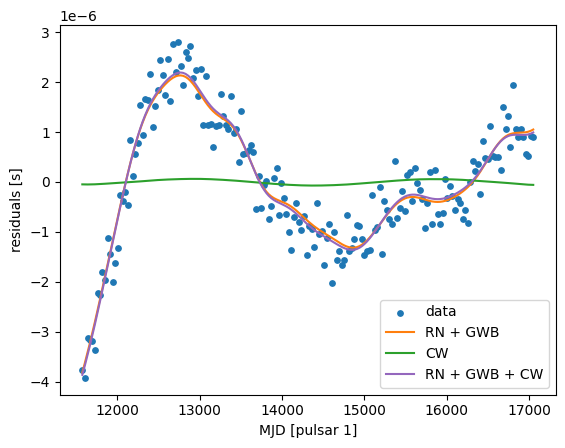

In [2]:
# plot data and injected signals
psr_ndx = 0
plt.scatter(m.MJDs[psr_ndx], m.Rs[psr_ndx] @ residuals[psr_ndx], color='C0', s=15, label='data')
if m.model_gwb or m.model_rn:
    rn_gwb_residuals_inj = m.Rs[psr_ndx] @ m.Fs[psr_ndx] @ m.a_inj.reshape((m.Np, m.Na))[psr_ndx]
    plt.plot(m.MJDs[psr_ndx], rn_gwb_residuals_inj, color='C1', label='RN + GWB')
if m.model_cw:
    cw_residuals_inj = m.Rs[psr_ndx] @ m.Fs[psr_ndx] @ m.get_CW_coefficients(m.x_inj[m.cw_psr_ndxs])[psr_ndx]
    plt.plot(m.MJDs[psr_ndx], cw_residuals_inj, color='C2', label='CW')
if (m.model_gwb or m.model_rn) and m.model_cw:
    plt.plot(m.MJDs[psr_ndx], rn_gwb_residuals_inj + cw_residuals_inj, color='C4', label='RN + GWB + CW')
plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
plt.ylabel('residuals [s]')
plt.legend()
plt.show()

In [3]:
# posterior density
@jit
def lnpost(x):

    # unpack parameters
    efacs = x[m.efac_ndxs]
    rn_hypers = x[m.rn_ndxs]
    gwb_hypers = x[m.gwb_ndxs]
    cw_psr_params = x[m.cw_psr_ndxs]
    psr_dists = x[m.psr_dist_ndxs]
    a = x[m.a_ndxs]

    # prior
    lnprior_val = l.uniform_lnprior(x)
    lnprior_val += l.a_lnprior_rn_gwb(rn_hypers, gwb_hypers, a)
    lnprior_val += l.psr_dist_lnprior(psr_dists)

    # likelihood
    a_cw = m.get_CW_coefficients(cw_psr_params).flatten()
    lnlike_val = l.lnlike(efacs, a + a_cw)

    return lnprior_val + lnlike_val

vectorized_lnpost = jit(vmap(lnpost))

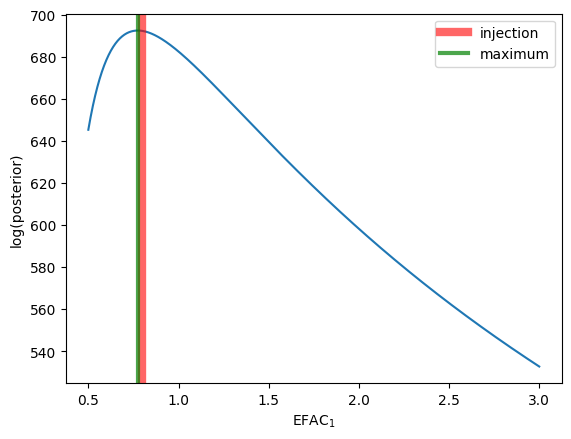

In [4]:
# plot cross-section of posterior
param_ndx = 0
num_evals = 1000
param_vals = jnp.linspace(m.x_mins[param_ndx], m.x_maxs[param_ndx], num_evals)
params = jnp.tile(m.x_inj, (num_evals, 1))
params = params.at[:, param_ndx].set(param_vals)
lnposts = vectorized_lnpost(params)
plt.plot(param_vals, lnposts)
plt.axvline(m.x_inj[param_ndx], color='red', label='injection', lw=6, alpha=0.6)
plt.axvline(param_vals[jnp.argmax(lnposts)], color='green', label='maximum', lw=3, alpha=0.7)
plt.legend()
plt.xlabel(m.x_labels[param_ndx])
plt.ylabel('log(posterior)')
plt.show()

In [5]:
@jit
def transform_a(rn_hypers, gwb_hypers, a_standard):
    rn_phi = jnp.zeros((m.Na, m.Np, m.Np))
    rn_phi = rn_phi.at[:, jnp.arange(m.Np), jnp.arange(m.Np)].set(m.vectorized_get_rho_diag(rn_hypers.reshape((m.Np, 2))).T)
    gwb_phi = m.get_rho_diag(gwb_hypers)[:, None, None] * m.alpha[None, :, :]
    phi = rn_phi + gwb_phi
    Lc = vmap(lambda x: jsl.cholesky(x, lower=True))(phi)
    a_transformed = vmap(lambda L, x: L @ x)(Lc, a_standard.reshape((m.Np, m.Na)).T).T.flatten()
    return a_transformed

In [6]:
def sampling_model():
    # uniform prior on hyper-parameters
    efacs = numpyro.sample('efacs', dist.Uniform(m.efac_mins, m.efac_maxs))
    rn_hypers = numpyro.sample('rn_hypers', dist.Uniform(m.rn_mins, m.rn_maxs))
    gwb_hypers = numpyro.sample('gwb_hypers', dist.Uniform(m.gwb_mins, m.gwb_maxs))

    # uniform prior on CW parameters and pulsar phases
    cw_params = numpyro.sample('cw', dist.Uniform(m.cw_mins, m.cw_maxs))
    psr_phases = numpyro.sample('psr_phases', dist.Uniform(m.psr_phase_mins, m.psr_phase_maxs))

    # normal prior on pulsar distances
    psr_dists = numpyro.sample('psr_dists', dist.Normal(m.psr_dists_inj, m.psr_dists_stdev))

    # normal prior on Fourier coefficients
    a_standard = numpyro.sample('a_standard', dist.Normal().expand([m.Na_PTA]))
    a_transformed = transform_a(rn_hypers, gwb_hypers, a_standard)
    a = numpyro.deterministic('a', a_transformed)

    # get CW coefficients
    a_cw = m.get_CW_coefficients(jnp.concatenate((cw_params, psr_phases, psr_dists))).flatten()

    # likelihood
    numpyro.factor('ln_likelihood', l.lnlike(efacs, a + a_cw))

In [34]:
nuts_kernel = numpyro.infer.NUTS(sampling_model)
mcmc = numpyro.infer.MCMC(sampler=nuts_kernel,
                          num_warmup=int(1e4),
                          num_samples=int(5e4))
mcmc.run(jr.key(0))
samples_dict = mcmc.get_samples()

sample: 100%|██████████| 60000/60000 [52:47<00:00, 18.94it/s, 1023 steps of size 4.17e-03. acc. prob=0.91]


In [35]:
samples = np.concatenate((samples_dict['efacs'],
                          samples_dict['rn_hypers'],
                          samples_dict['gwb_hypers'],
                          samples_dict['cw'],
                          samples_dict['psr_phases'],
                          samples_dict['psr_dists'],
                          samples_dict['a']), axis=1)

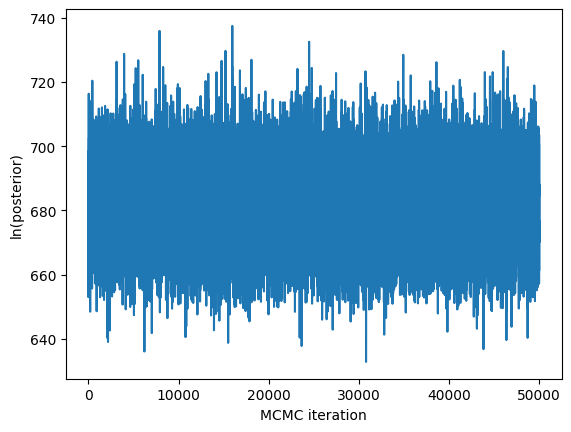

In [36]:
# plot posterior values
lnposts = vectorized_lnpost(samples)
plt.plot(lnposts)
plt.xlabel('MCMC iteration')
plt.ylabel('ln(posterior)')
plt.show()

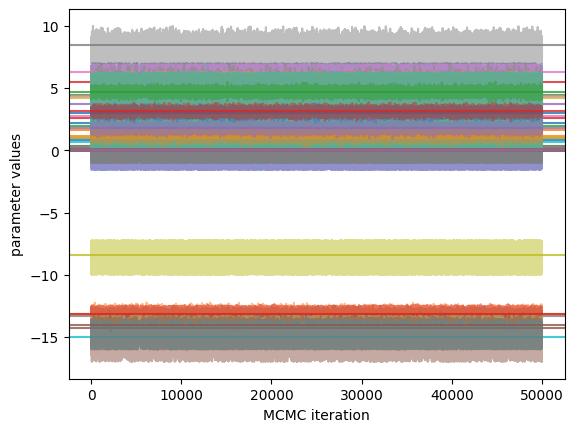

In [37]:
# trace plot
for i in range(m.ndim):
    plt.plot(samples[:, i], color=f'C{i}', alpha=0.5)
    plt.axhline(m.x_inj[i], color=f'C{i}', alpha=0.8)
plt.xlabel('MCMC iteration')
plt.ylabel('parameter values')
plt.show()

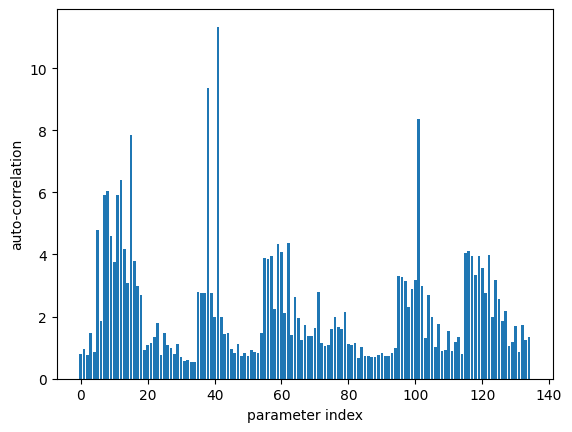

In [38]:
# plot auto-correlations
auto_corrs = np.array([integrated_time(samples[:, i])[0] for i in range(m.ndim)])
plt.bar(np.arange(m.ndim), auto_corrs)
plt.xlabel('parameter index')
plt.ylabel('auto-correlation')
plt.show()

Parameter $\log_{10}\,A_{1}$ in chain HMC is not constrained
Parameter $\gamma_{1}$ in chain HMC is not constrained


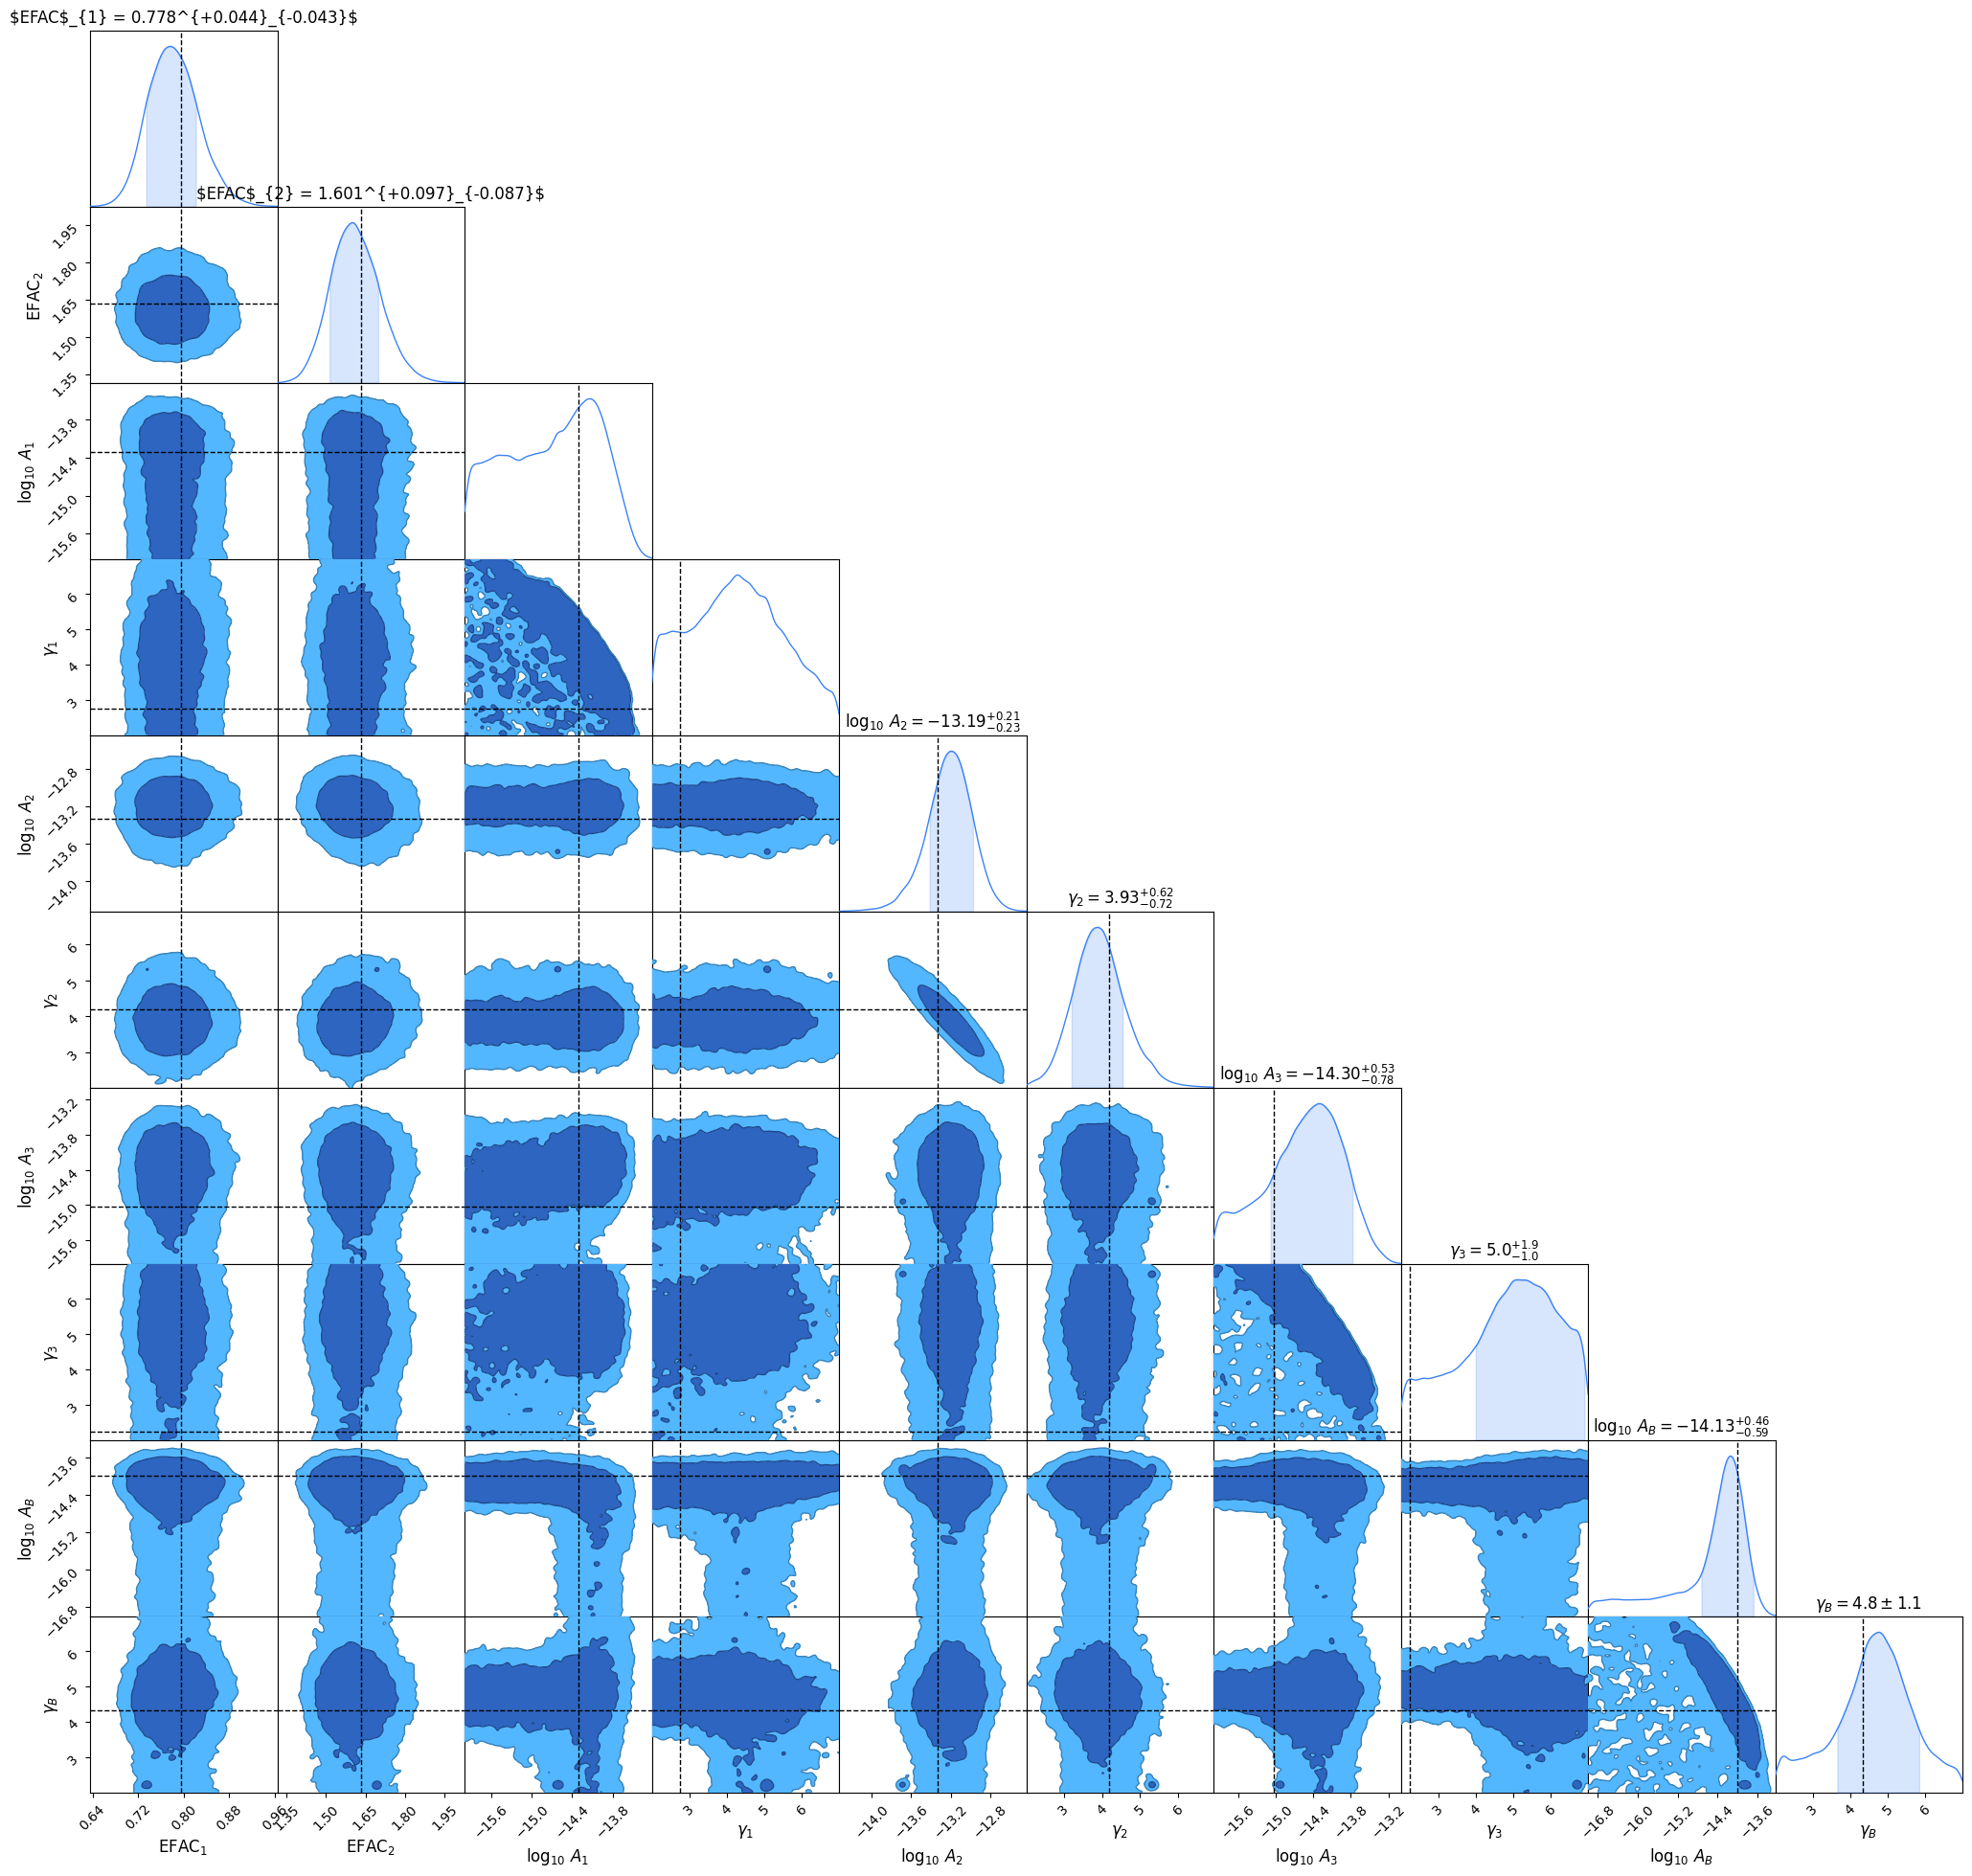

In [50]:
# corner plot
ndxs = np.concatenate((m.efac_ndxs[:2], m.rn_ndxs[:6], m.gwb_ndxs))
df = pd.DataFrame(samples, columns=m.x_labels)
c = ChainConsumer()
c.add_chain(Chain(samples=df.iloc[:, ndxs], name='HMC'))
c.add_truth(Truth(location={name: val for name, val in zip(m.x_labels, m.x_inj)}))
fig = c.plotter.plot()

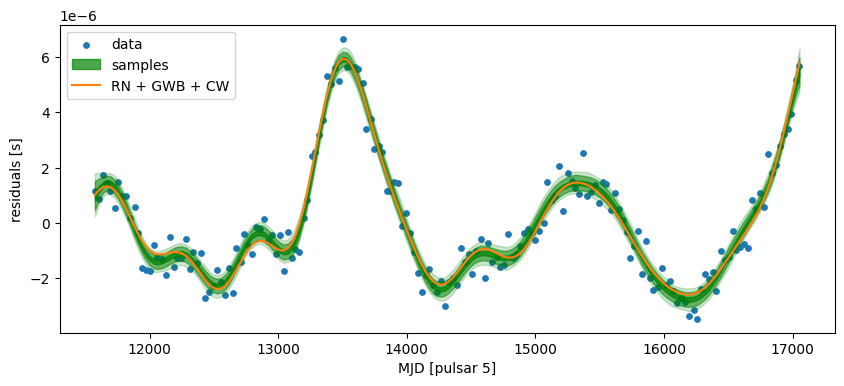

In [46]:
# Bayesogram
psr_ndx = 4
fair_draw_ndxs = np.random.choice(samples.shape[0], (1000,))
a_cws = np.array([m.get_CW_coefficients(samples[ndx, m.cw_psr_ndxs])[psr_ndx]
                  for ndx in fair_draw_ndxs])
signals = np.array([m.Rs[psr_ndx] @ m.Fs[psr_ndx] @ (samples[ndx, m.a_ndxs].reshape((m.Np, m.Na))[psr_ndx] + a_cw)
                    for ndx, a_cw in zip(fair_draw_ndxs, a_cws)])

# plot data, samples, and injected signals
plt.figure(figsize=(10, 4))
plt.scatter(m.MJDs[psr_ndx], m.Rs[psr_ndx] @ residuals[psr_ndx], color='C0', s=15, label='data')
plt.fill_between(m.MJDs[psr_ndx], np.percentile(signals, 0.5, axis=0), np.percentile(signals, 99.5, axis=0),
                 color='green', alpha=0.2)
plt.fill_between(m.MJDs[psr_ndx], np.percentile(signals, 5.0, axis=0), np.percentile(signals, 95., axis=0),
                 color='green', alpha=0.5)
plt.fill_between(m.MJDs[psr_ndx], np.percentile(signals, 30., axis=0), np.percentile(signals, 70., axis=0),
                 color='green', alpha=0.7, label='samples')
rn_gwb_residuals_inj = m.Rs[psr_ndx] @ m.Fs[psr_ndx] @ m.a_inj.reshape((m.Np, m.Na))[psr_ndx]
cw_residuals_inj = m.Rs[psr_ndx] @ m.Fs[psr_ndx] @ m.get_CW_coefficients(m.x_inj[m.cw_psr_ndxs])[psr_ndx]
plt.plot(m.MJDs[psr_ndx], rn_gwb_residuals_inj + cw_residuals_inj, color='C1', label='RN + GWB + CW')
plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
plt.ylabel('residuals [s]')
plt.legend()
plt.show()